# 사진 묘사하기 시험 유형 만들기

사진 묘사하기 시험도 마찬가지 GPT-4-vision API는 특히 더 느리기 때문에 시험을 위한 준비를 먼저 해둬서 비싸고 재반복하는 연산은 미리 해두는게 좋음

- 사진 준비하기
- 사진에 대한 Reference 설명 만들기
- 이미지, Reference 설명을 참조하여 사용자의 설명 평가하기

In [5]:
import pandas as pd
from openai import OpenAI
from IPython.display import Image

client = OpenAI()

## create_desc 함수 만들기

In [6]:
import base64

In [7]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8') #이미지를 인코딩하여 문자열을 전송하면, openAI가 그 이미지 문자열을 decoding 하여 인식함.

In [8]:
def create_desc(img_path):
    base64_image = encode_image(img_path) #img_path라는 이미지 파일 주소를 받음.
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
              "role": "user",
              "content": [
                {"type": "text", "text": "Describe given image."},
                {
                  "type": "image_url",
                  "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}", #인코딩된 텍스트를 넣어줌.
                  },
                },
              ],
            }
            ],
            max_tokens=300
        )
    text = response.choices[0].message.content
    return text

In [9]:
!ls ./imgs

1.jpg
2.jpg
3.jpg
4.png


In [10]:
from glob import glob

In [11]:
img_list = glob("./imgs/*")

In [12]:
img_list

['./imgs\\1.jpg', './imgs\\2.jpg', './imgs\\3.jpg', './imgs\\4.png']

In [13]:
img_path = "./imgs/4.png"

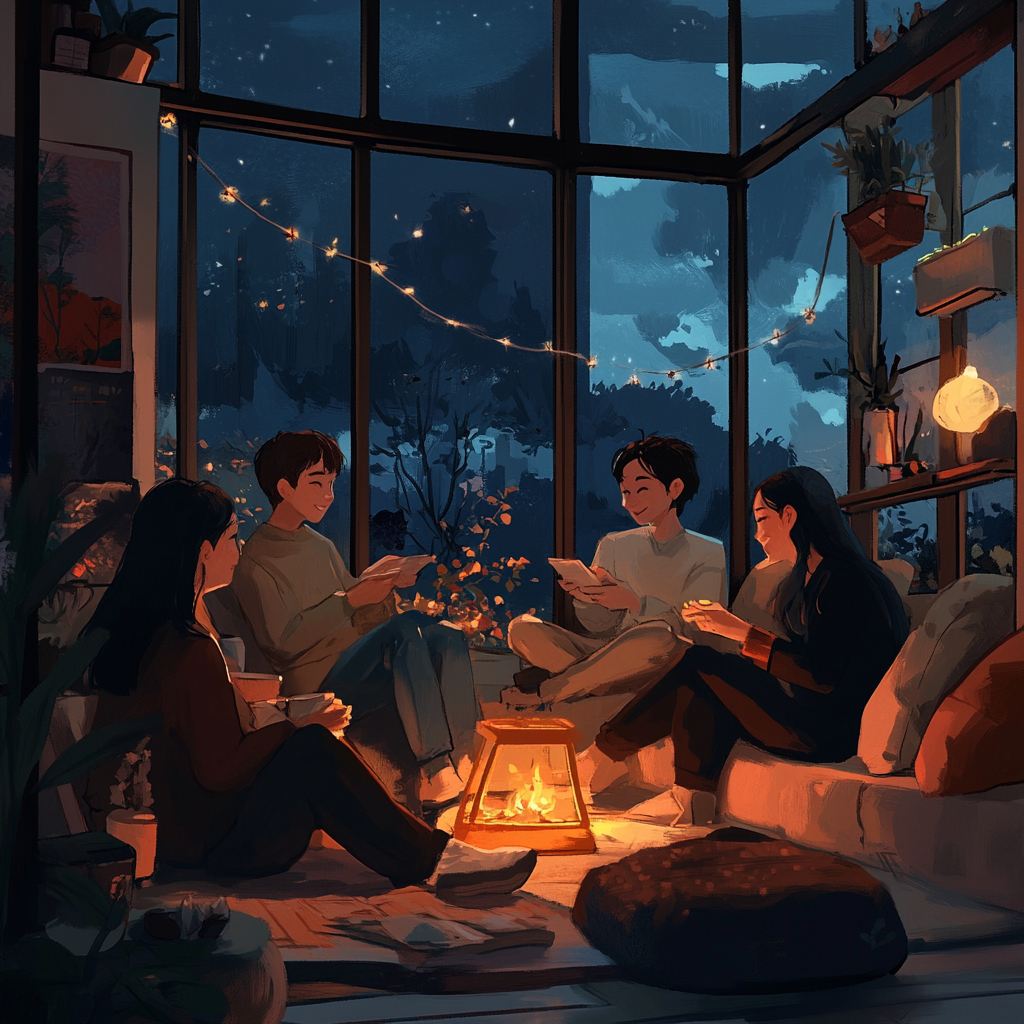

In [14]:
Image(img_path, width=480)

In [11]:
create_desc(img_path=img_path)

"The image depicts a cozy indoor setting illuminated by warm lights and a small fire. Four people are gathered together, sitting comfortably on the floor in a relaxed manner, enjoying each other's company. They appear to be engaged in some activity involving cards or notes, all while surrounded by a gently lit environment featuring plants and decorative elements. The large windows reveal a night sky with stars and clouds, enhancing the warm and inviting ambiance of the scene. The overall atmosphere conveys friendship and warmth, perfect for a peaceful evening gathering."

## 이미지 모두 불러오기

In [12]:
from glob import glob

In [13]:
img_list = glob("./imgs/*.jpg")

In [14]:
img_list

['./imgs\\1.jpg', './imgs\\2.jpg', './imgs\\3.jpg']

In [ ]:
#이미지를 GPT를 이용하여 설명문을 출력함.

In [ ]:
record_list = []

for i, img_path in enumerate(img_list):
    desc = create_desc(img_path)
    record = {"img_path": img_path, "desc": desc}
    print(record)

    record_list.append(record)

{'img_path': './imgs\\1.jpg', 'desc': 'The image depicts a cozy indoor scene featuring a family. In the foreground, a father and his daughter are lying on the floor, engaged in a drawing activity. The father, smiling, interacts lovingly with his daughter, who appears to be about to draw or write, showcasing their bonding time. \n\nIn the background, a woman casually sits on a couch, looking at her phone, suggesting a relaxed environment. The setting is well-lit with natural light coming through window blinds, and there are decorative elements like potted plants and colorful cushions that add to the warmth of the room. Overall, the scene conveys feelings of family togetherness and leisure.'}


In [16]:
!mkdir -p ./data/speaking__describe_img

명령 구문이 올바르지 않습니다.


In [3]:
save_dir = "./data/speaking__describe_img"

In [4]:
#이미지 저장주소와 이미지 설명 저장.
df = pd.DataFrame(record_list)
df

NameError: name 'pd' is not defined

In [19]:
df.to_csv(f"{save_dir}/desc_img.csv", index=False)

## 평가하기

In [20]:
from langchain_openai import ChatOpenAI
from typing import Union
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

C:\Users\msh07\miniconda3\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
model = ChatOpenAI(model="gpt-4-1106-preview", temperature=0.8) # CoT 는 다양한 샘플을 만들어야하기 때문에 temperature를 올려야함

In [22]:
class Evaluation(BaseModel):
    score: int = Field(description="사진 묘사하기 표현 점수. 0~10점")
    feedback: str = Field(description="사진 묘사하기를 더 잘 할 수 있도록하는 자세한 피드백. Markdown형식, 한국어로.")

In [23]:
parser = JsonOutputParser(pydantic_object=Evaluation)
format_instructions = parser.get_format_instructions()
format_instructions

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"score": {"title": "Score", "description": "사진 묘사하기 표현 점수. 0~10점", "type": "integer"}, "feedback": {"title": "Feedback", "description": "사진 묘사하기를 더 잘 할 수 있도록하는 자세한 피드백. Markdown형식, 한국어로.", "type": "string"}}, "required": ["score", "feedback"]}\n```'

In [24]:
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate

human_prompt_template = HumanMessagePromptTemplate.from_template(
                            "사진 묘사하기 영어 시험이다. 사용자의 응답을 Reference와 비교하여 평가하라.\n사용자: {input}\Reference: {ref}\n{format_instructions}",
                            partial_variables={"format_instructions": format_instructions})

prompt = ChatPromptTemplate.from_messages(
    [
        human_prompt_template,
    ])

<>:4: SyntaxWarning: invalid escape sequence '\R'
<>:4: SyntaxWarning: invalid escape sequence '\R'
C:\Users\msh07\AppData\Local\Temp\ipykernel_23648\1829478573.py:4: SyntaxWarning: invalid escape sequence '\R'
  "사진 묘사하기 영어 시험이다. 사용자의 응답을 Reference와 비교하여 평가하라.\n사용자: {input}\Reference: {ref}\n{format_instructions}",


In [25]:
eval_chain = prompt | model | parser

In [26]:
sample = df.iloc[0]

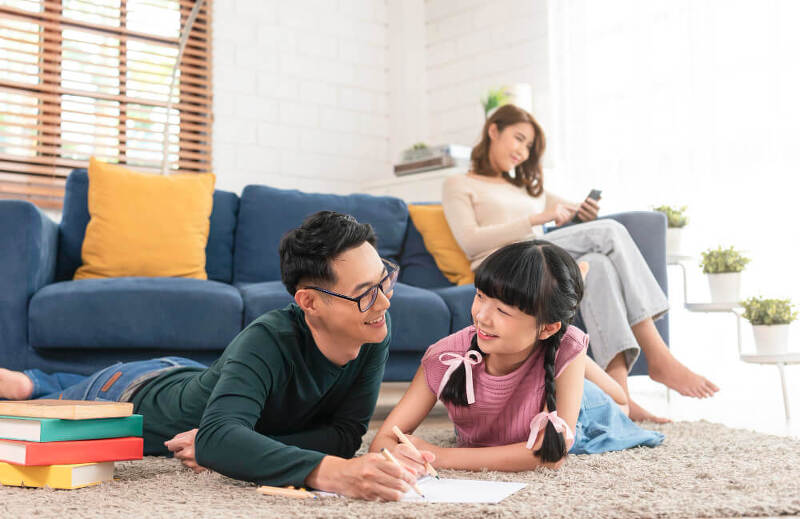

In [27]:
Image(sample['img_path'], width=480)

In [28]:
sample['desc']

'The image shows a cozy living room scene. A father and his daughter are lying on the floor, smiling and engaged in an activity together. The daughter appears to be drawing or writing, while the father looks at her with a supportive expression. In the background, a woman, likely the mother, is sitting on a couch and using her phone, seemingly relaxed. The room is well-lit and decorated with plants and comfortable furnishings, creating a warm and inviting atmosphere. There are also a few colorful books stacked nearby.'

In [37]:
result = eval_chain.invoke({"input": "There are three people in a room. a woman is sitting on a couch and a man and a girl is lying on the floor.",
                            "ref": sample['desc']})

In [38]:
result

{'score': 5,
 'feedback': '사진 묘사를 할 때 사람들의 활동이나 감정, 그리고 주변 환경에 대한 자세한 설명을 포함하는 것이 좋습니다. 예를 들어, 남자와 여자아이가 바닥에 누워 그림을 그리고 있다거나, 여성이 휴대폰을 사용하고 있다는 등의 구체적인 행동을 묘사하면 독자가 더 생생하게 상황을 이해할 수 있습니다. 또한, 인물의 복장이나 방 안의 가구, 장식품에 대한 정보도 포함시켜 방의 분위기를 전달하는 것이 좋습니다. 인물들 사이의 관계나 감정도 함께 묘사하면 사진에 대한 이해도를 높일 수 있습니다.'}